In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split


import keras
from keras.layers import Dense
from keras.models import Sequential


from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer

from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

Using TensorFlow backend.


In [2]:
# Read the dataset
df = pd.read_csv("D:/Projects/Real Vs Fake Jobs Indentifier/Data/fake_job_postings.csv")

In [3]:
# Dislay dataframe
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
df.shape #Check no of data avaiable in the dataset

(17880, 18)

In [5]:
df.dtypes   #Check data types of each attrbute in the daraframe

job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

In [6]:
df.isna().sum()   #Check no of NA values in each attribute

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [7]:
df.fillna(value='No information',inplace=True)   #replace NA values with word 'No Inforamtion' 

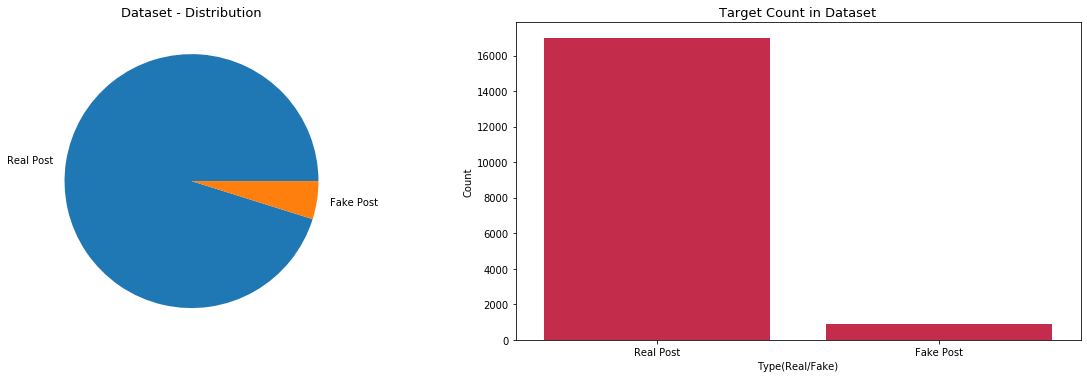

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 5))  
plt.tight_layout()

# Count number of fake job positions in the data set and plot it into a pie chart
df["fraudulent"].value_counts().plot(kind='pie', ax=axes[0], labels=['Real Post', 'Fake Post'])

# Count number of Fake job positions in the data set
fraudulent_count= df["fraudulent"].value_counts()
sns.barplot(fraudulent_count.index,fraudulent_count, ax=axes[1],color='crimson')  #Add data in to the Bar Blot
axes[0].set_ylabel('')

axes[1].set_xlabel('Type(Real/Fake)')    #Set name of the x axis of the bar plot
axes[1].set_ylabel('Count')              #Set y axis of the bar plot
axes[1].set_xticklabels(["Real Post", "Fake Post"]) 

axes[0].set_title('Dataset - Distribution', fontsize=13)
axes[1].set_title('Target Count in Dataset', fontsize=13)

plt.show()

In [9]:
x_corr = df.corr()  #GEtting Cor relations of each attribute 
x_corr

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
job_id,1.000000,-0.004559,-0.014539,-0.087025,0.079872
telecommuting,-0.004559,1.000000,-0.019836,0.020345,0.034523
has_company_logo,-0.014539,-0.019836,1.000000,0.233932,-0.261971
has_questions,-0.087025,0.020345,0.233932,1.000000,-0.091627
fraudulent,0.079872,0.034523,-0.261971,-0.091627,1.000000


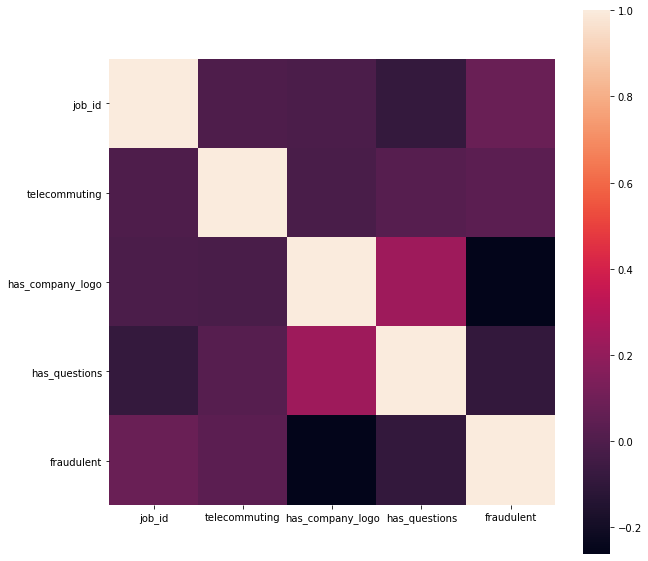

In [10]:
plt.figure(figsize = (10,10))  
sns.heatmap(x_corr , square = True) #Display Coorelations in the heatmap

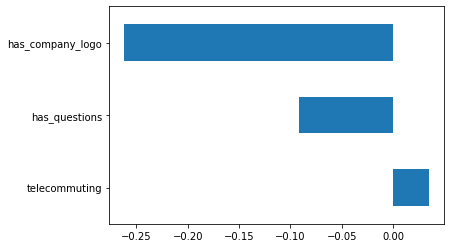

In [11]:
(x_corr.fraudulent.drop('job_id').drop('fraudulent').sort_values(ascending=False).plot.barh()) #Display Correaltion in bar chart

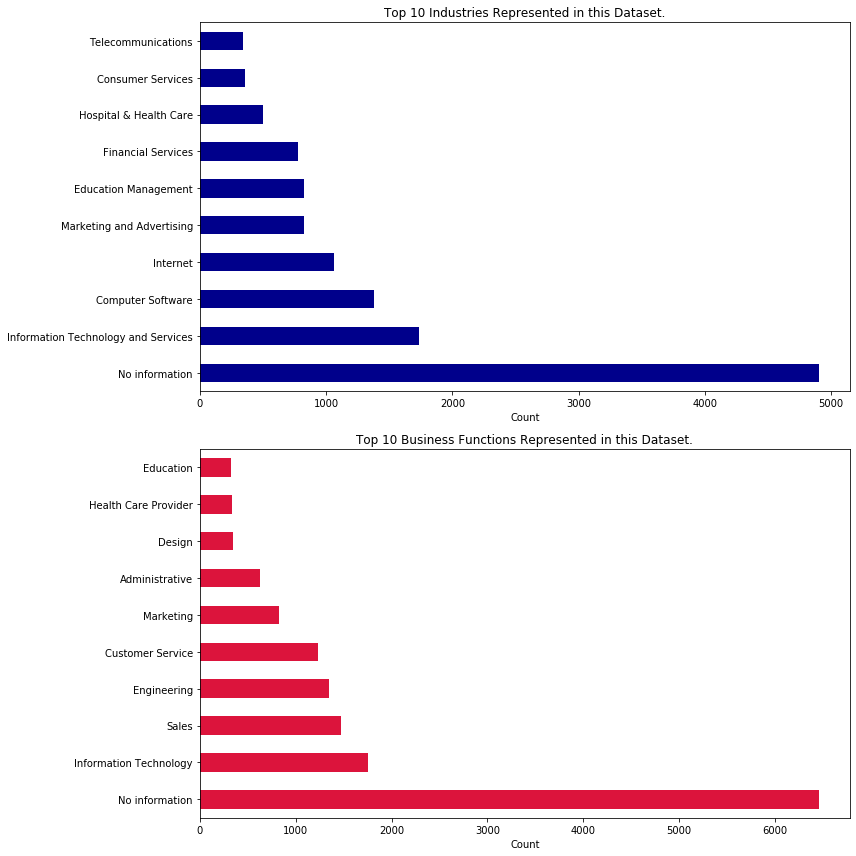

In [12]:
industry = df.industry.value_counts()[:10]         #Count adds in each industry and get top 10 
function = df.function.value_counts()[:10]         #Count adds in each function adn get top 10

plt.figure(figsize = (12,12))

# Plot Count of top 10 Industries
plt.subplot(2,1,1)
industry.plot(kind = 'barh',color="darkblue")
plt.title('Top 10 Industries Represented in this Dataset.')
plt.xlabel('Count')

# Prolt count of top 10 Functions
plt.subplot(2,1,2)
function.plot(kind = 'barh',color="crimson")
plt.title('Top 10 Business Functions Represented in this Dataset.')
plt.xlabel('Count')

plt.tight_layout()
plt.show()

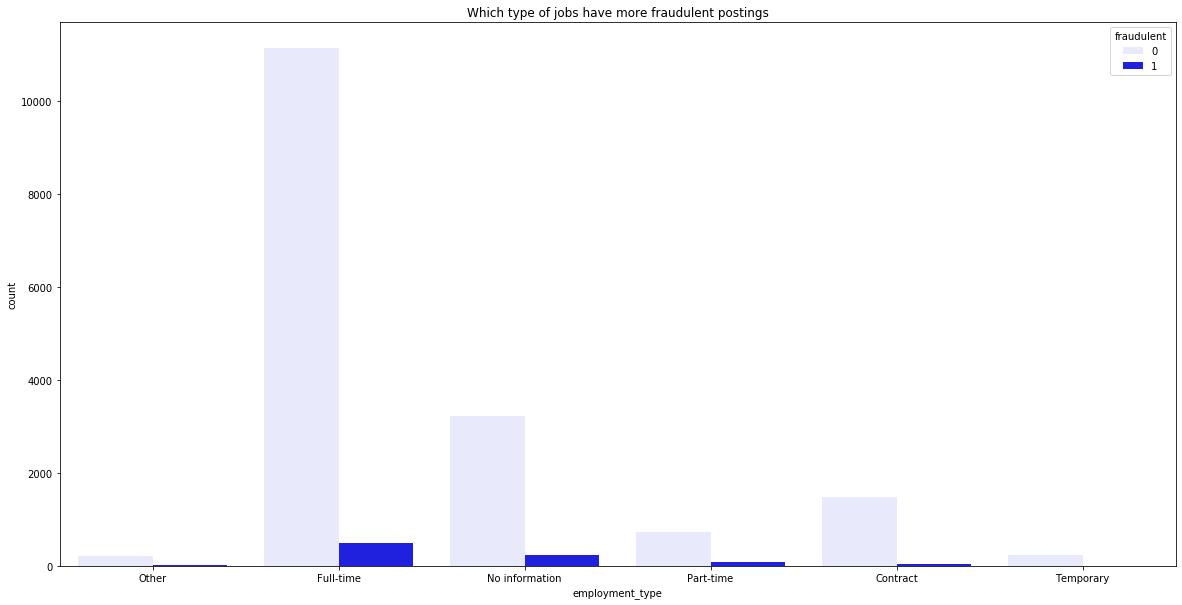

In [13]:
# Display fakse job posts in each employment types
plt.figure(1,figsize=(20,10))
sns.countplot(hue=df.fraudulent,x=df.employment_type,color = 'blue');
plt.title('Which type of jobs have more fraudulent postings');

(0, 800)

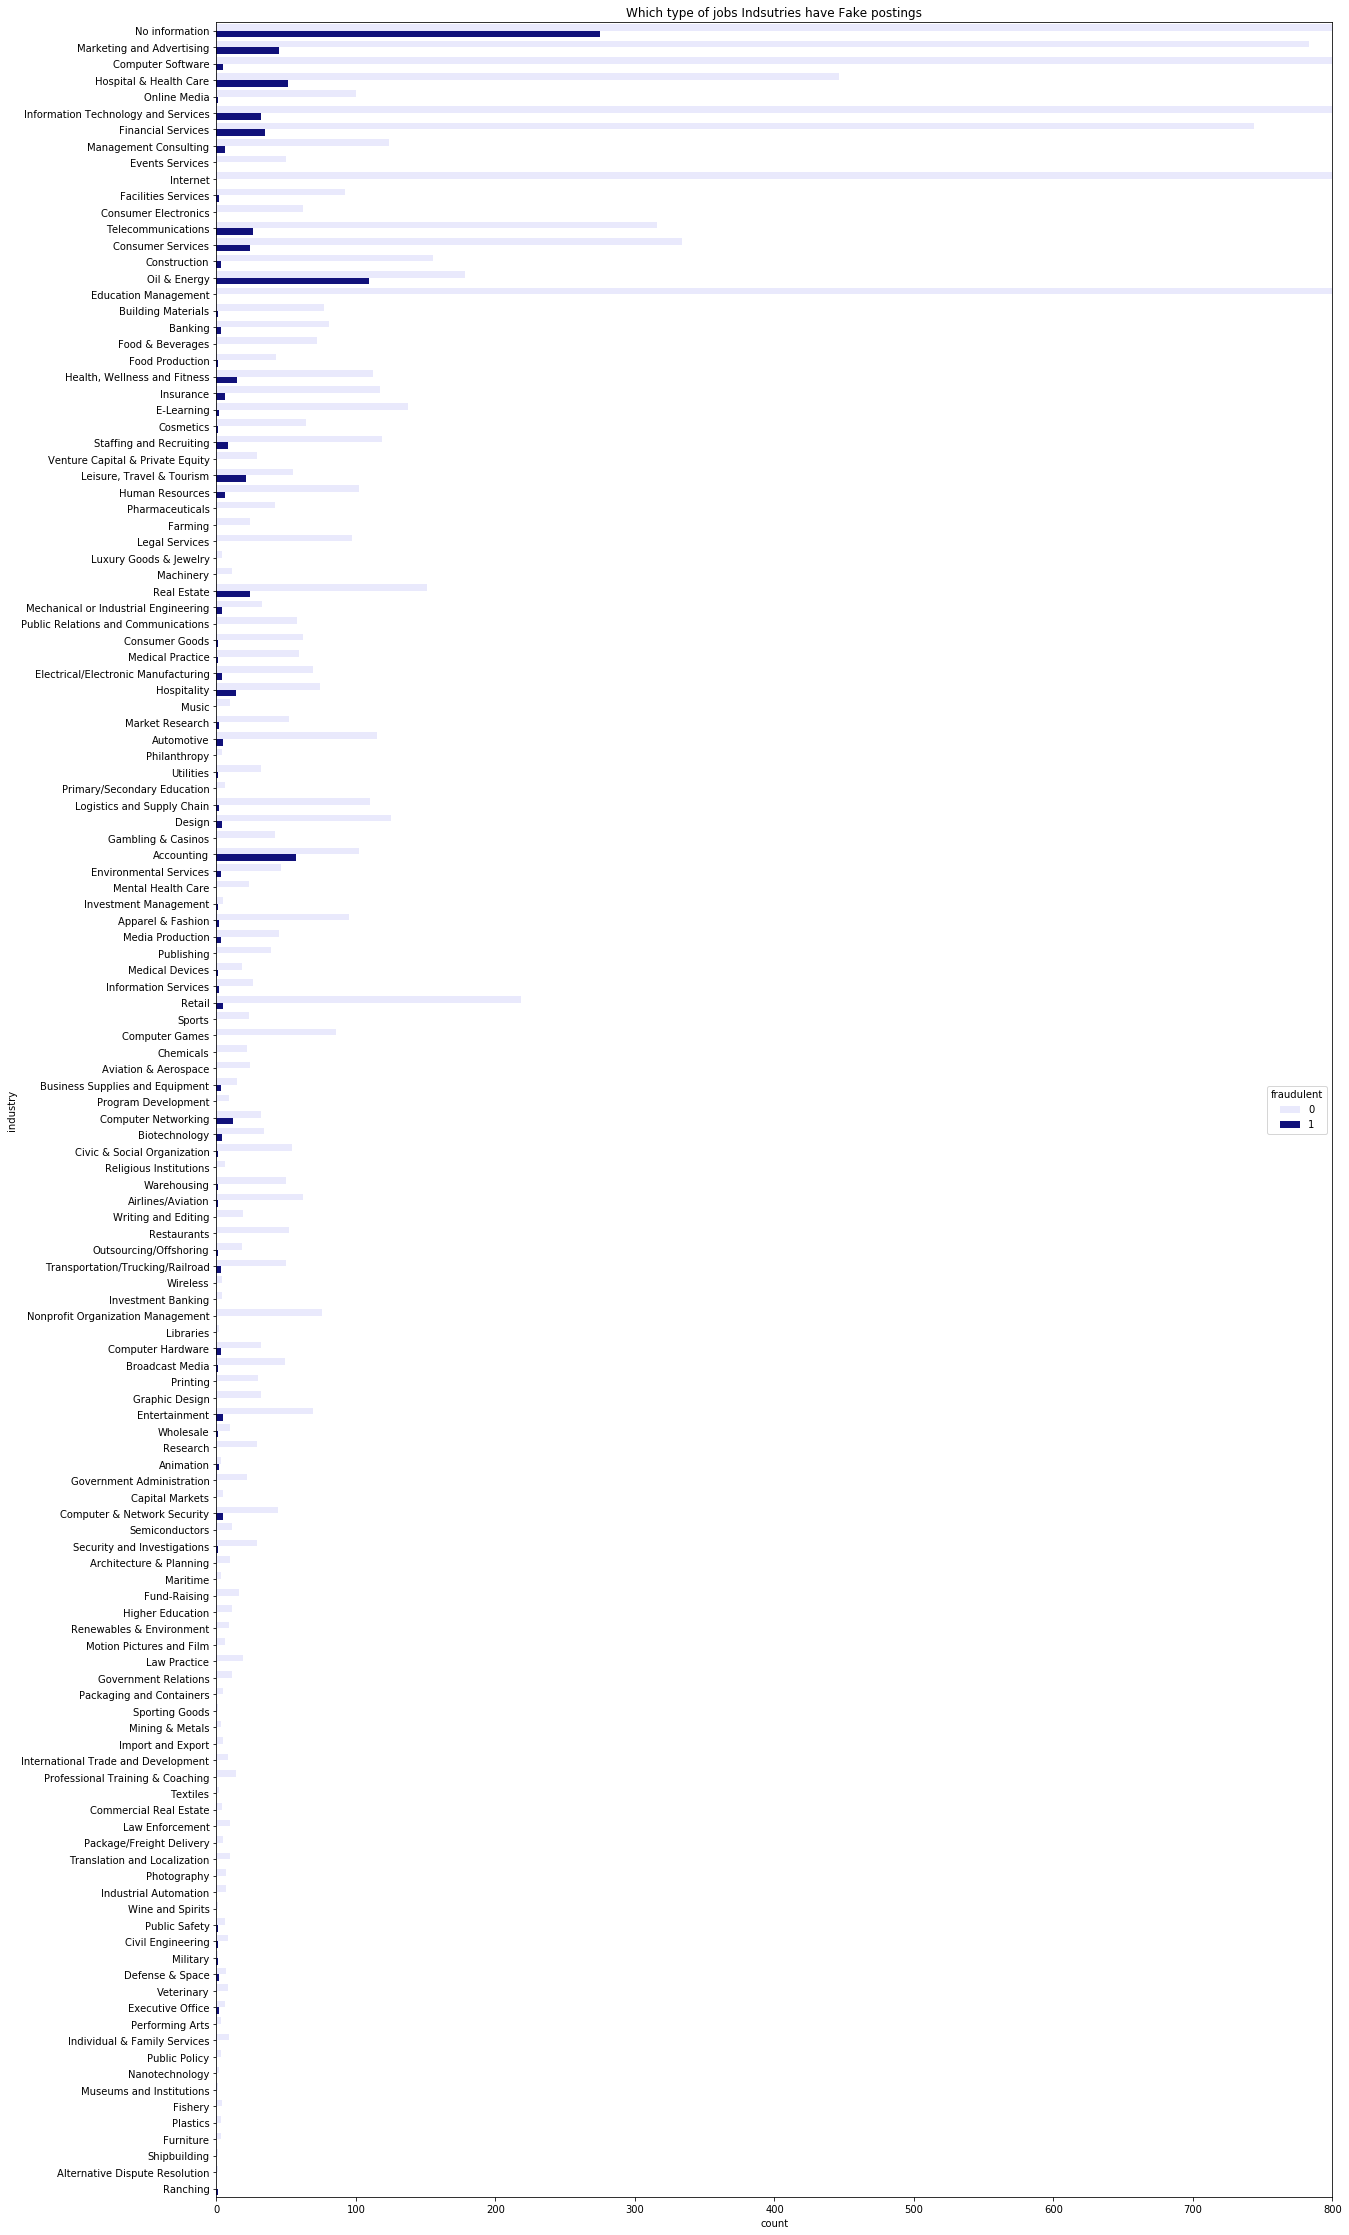

In [14]:
# Plot how fake jobs in each job indsutry
plt.figure(figsize=(20,40))
sns.countplot(y=df.industry,hue=df.fraudulent,color='darkblue');
plt.title('Which type of jobs Indsutries have Fake postings');
plt.xlim(0,800)  #Set Limits of X axis

(0, 800)

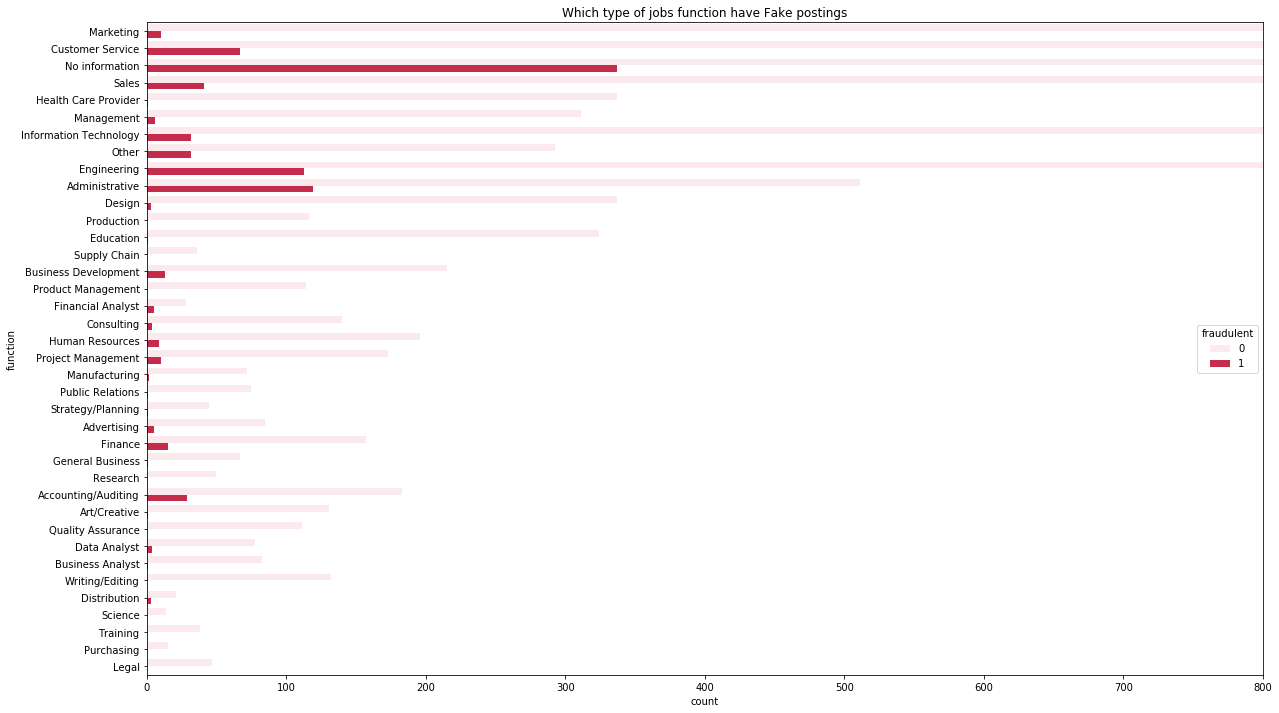

In [15]:
# PLot how fake jobs in each job function 
plt.figure(figsize=(20,12))
sns.countplot(y=df.function,hue=df.fraudulent,color="crimson");
plt.title('Which type of jobs function have Fake postings');
plt.xlim(0,800) #Set Limits of X axis

In [16]:
# Extract Columns with categories
categorical_columns = []
for col in df.columns:
    print(f'Unique rows in {col}:', df[col].nunique())
    if df[col].nunique() < 133:
        categorical_columns.append(col)
print('Categorical columns:',categorical_columns)

Unique rows in job_id: 17880
Unique rows in title: 11231
Unique rows in location: 3106
Unique rows in department: 1338
Unique rows in salary_range: 875
Unique rows in company_profile: 1710
Unique rows in description: 14802
Unique rows in requirements: 11969
Unique rows in benefits: 6206
Unique rows in telecommuting: 2
Unique rows in has_company_logo: 2
Unique rows in has_questions: 2
Unique rows in employment_type: 6
Unique rows in required_experience: 8
Unique rows in required_education: 14
Unique rows in industry: 132
Unique rows in function: 38
Unique rows in fraudulent: 2
Categorical columns: ['telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent']


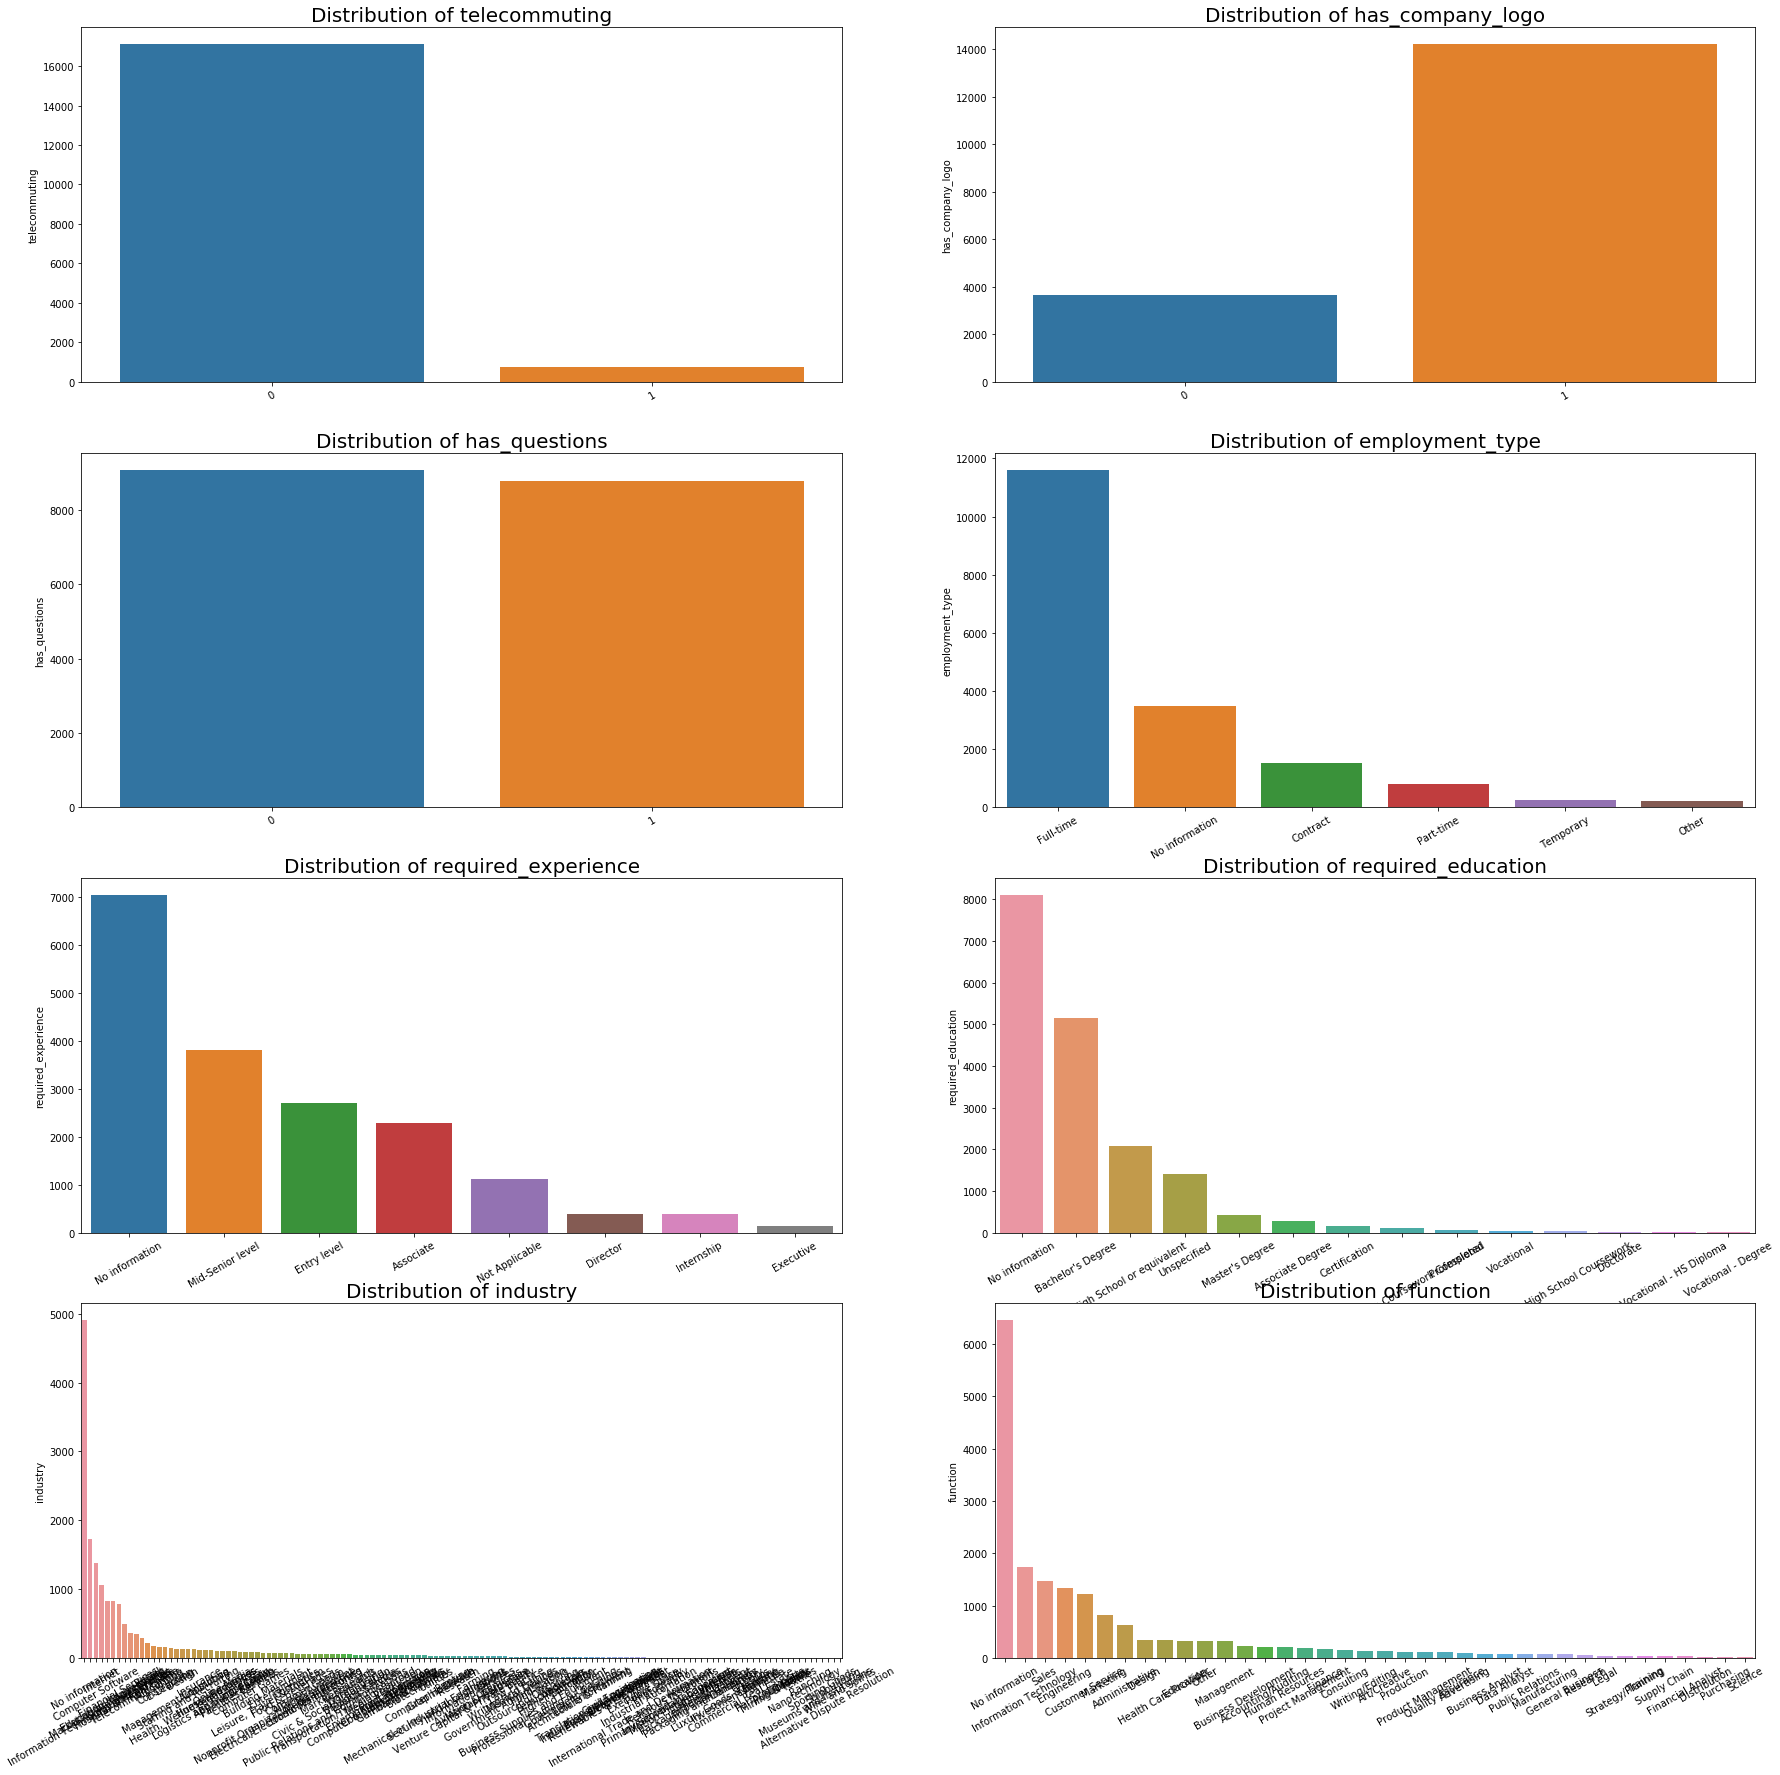

In [17]:
# Print fraudlent in each categories
fig, axs = plt.subplots(len(categorical_columns)//2 , 2, figsize = (30,30))
plt_row = 0
plt_col = 0
for i, col in enumerate(categorical_columns):
    if col == 'fraudulent':
        continue
    _ = df[col].value_counts()
    sns.barplot(_.index, _, ax = axs[plt_row][plt_col])
    axs[plt_row][plt_col].set_title(f'Distribution of {col}', size = 20)
    for tick in axs[plt_row,plt_col].get_xticklabels():
        tick.set_rotation(30)
    if plt_col == 0:
        plt_col = 1
    else:
        plt_col = 0
        plt_row += 1
plt.show()